# Prueba data scientist R5

## Juan David Rincón

##### 1. Cree una base de datos en PostgreSql (puede ser local) que debe contener una tabla llamada "fraudes" con la información contenida en ./data/fraude.csv. (el archivo ./data/create_table.txt te ayudará)

Los pasos para llevar a cabo la solución de este punto se encuentran en este repositorio en `\input\problema_posgres.sql`.
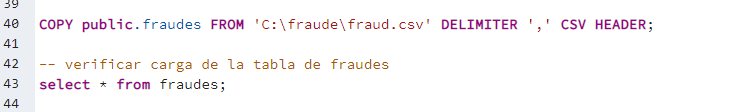


##### 2) Con su base de datos cargada escriba un query de SQL que replique la siguiente salida sin usar subconsultas.

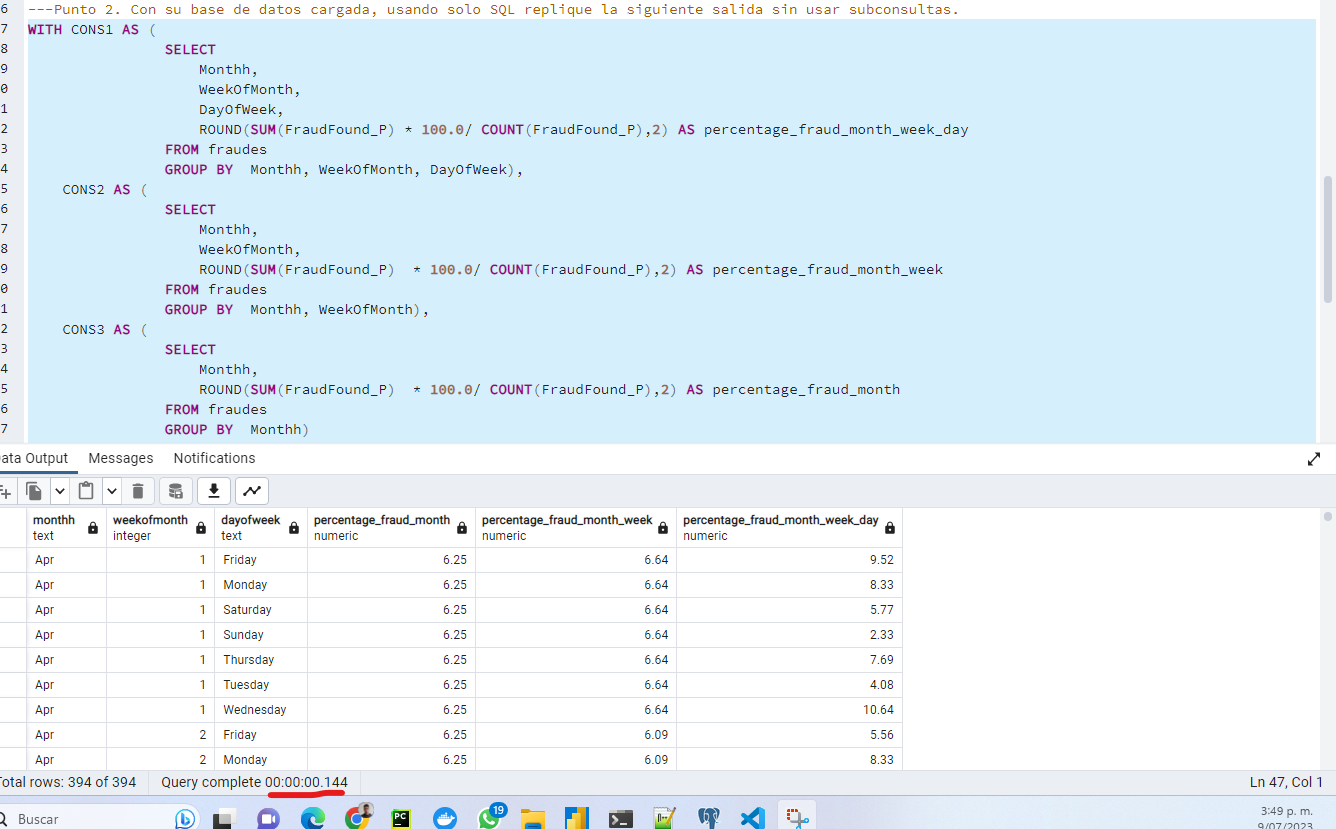

Cabe destacar, que el tiempo reqerido para esta consulta es menor al de la imagen que nos presentan en la prueba, esta nos puede indicar que mi pc la ejecutó sin ningún otro proceso que estuviese corriendo o que la querye presentada es más eficiente.


#### Importación de librerías extrarnas y propias para la solución de los demás puntos requeridos

In [134]:

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from scipy import stats

# Preprocesado y modelado
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
from sklearn.tree import export_text
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('once')


%cd ../../
from fraudes.python.utils.conection import read_table_from_bd
from fraudes.python.utils.grafic import raincloud_image
from fraudes.python.utils.correlaciones import correlaciones_chi2
from fraudes.python.utils.prepocesar_data import prepocesar_data

C:\


#### 3) conéctese desde Python o R a la tabla fraudes (la de la base de datos creada, no directamente del .csv) y léala con un query que la traiga lo más limpia posible.
En la estructura del repositorio, en `fraudes.python.utils.conection import read_table_from_bd` se podra encontrar lo solicitado empleando buenas practicas de desarrollo.
Dicha función se importará en este notebook para realizar el posterior analísis de los datos.


In [135]:
fraudes = read_table_from_bd()

In [136]:
fraudes.size

508860

In [137]:
fraudes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   monthh                15420 non-null  object
 1   weekofmonth           15420 non-null  int64 
 2   dayofweek             15420 non-null  object
 3   make                  15420 non-null  object
 4   accidentarea          15420 non-null  object
 5   dayofweekclaimed      15420 non-null  object
 6   monthclaimed          15420 non-null  object
 7   weekofmonthclaimed    15420 non-null  int64 
 8   sex                   15420 non-null  object
 9   maritalstatus         15420 non-null  object
 10  age                   15420 non-null  int64 
 11  fault                 15420 non-null  object
 12  policytype            15420 non-null  object
 13  vehiclecategory       15420 non-null  object
 14  vehicleprice          15420 non-null  object
 15  fraudfound_p          15420 non-null

#### (Extra) La siguiente fracción de código genera la misma consulta en SQL pero en Python

In [138]:
cols = ['monthh', 'weekofmonth', 'dayofweek',]
agg = {'fraudfound_p': [sum, 'count']}
week_day = fraudes.groupby(cols).agg(agg)
week_day.columns = ['suma', 'cantidad']
week_day.reset_index(inplace=True)

week_day['percentage_fraud_week_day'] = week_day['suma'] /week_day['cantidad'] * 100
week_day['percentage_fraud_week_day'] = week_day['percentage_fraud_week_day'].round(2)

cols = ['monthh', 'weekofmonth']
agg = {'fraudfound_p': [sum, 'count']}
weekofmonth = fraudes.groupby(cols).agg(agg)
weekofmonth.columns = ['suma', 'cantidad']
weekofmonth.reset_index(inplace=True)

weekofmonth['percentage_fraud_weekofmonth'] = weekofmonth['suma'] /weekofmonth['cantidad'] * 100
weekofmonth['percentage_fraud_weekofmonth'] = weekofmonth['percentage_fraud_weekofmonth'].round(2)

cols = ['monthh']
agg = {'fraudfound_p': [sum, 'count']}
mes = fraudes.groupby(cols).agg(agg)
mes.columns = ['suma', 'cantidad']
mes.reset_index(inplace=True)

mes['percentage_fraud_month'] = mes['suma'] /mes['cantidad'] * 100
mes['percentage_fraud_month'] = mes['percentage_fraud_month'].round(2)

consulta = pd.merge(
    week_day[['monthh', 'weekofmonth', 'dayofweek','percentage_fraud_week_day']],
    weekofmonth[['monthh', 'weekofmonth','percentage_fraud_weekofmonth']],
    on=['monthh', 'weekofmonth'])

consulta = pd.merge(
    consulta,
    mes[['monthh', 'percentage_fraud_month']],
    on=['monthh'])

cols_ord = [
    'monthh',
    'weekofmonth',
    'dayofweek',
    'percentage_fraud_month',
    'percentage_fraud_weekofmonth',
    'percentage_fraud_week_day' ]
consulta = consulta[cols_ord]
consulta

,monthh,weekofmonth,dayofweek,percentage_fraud_month,percentage_fraud_weekofmonth,percentage_fraud_week_day
0,Apr,1,Friday,6.25,6.64,9.52
1,Apr,1,Monday,6.25,6.64,8.33
2,Apr,1,Saturday,6.25,6.64,5.77
3,Apr,1,Sunday,6.25,6.64,2.33
4,Apr,1,Thursday,6.25,6.64,7.69
...,...,...,...,...,...,...
389,Sep,4,Wednesday,6.13,4.26,0.00
390,Sep,5,Friday,6.13,5.56,6.67
391,Sep,5,Saturday,6.13,5.56,7.69
392,Sep,5,Thursday,6.13,5.56,2.17


# Exploración de la información

### Rain Cloud Images para la exploración de valores atípicos en la edad de las personas que hacen la denuncia.

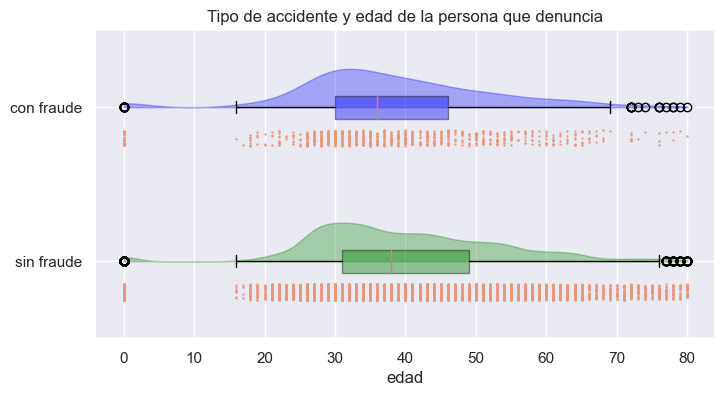

In [139]:
sin_fraude = fraudes[fraudes.fraudfound_p==0]
con_fraude = fraudes[fraudes.fraudfound_p==1]
data_x = [sin_fraude.age.to_numpy(), con_fraude.age.to_numpy()]
feats = ['sin fraude', 'con fraude']
value = 'edad'
title = 'Tipo de accidente y edad de la persona que denuncia'

raincloud_image(data_x, feats, value, title)

In [140]:
q25 = np.percentile(con_fraude.age, 25)
q75 = np.percentile(con_fraude.age, 75)
print(f'Rango de edad de personas que hacen denuncia que son fraudes {q25 , q75}')

Rango de edad de personas que hacen denuncia que son fraudes (30.0, 46.0)


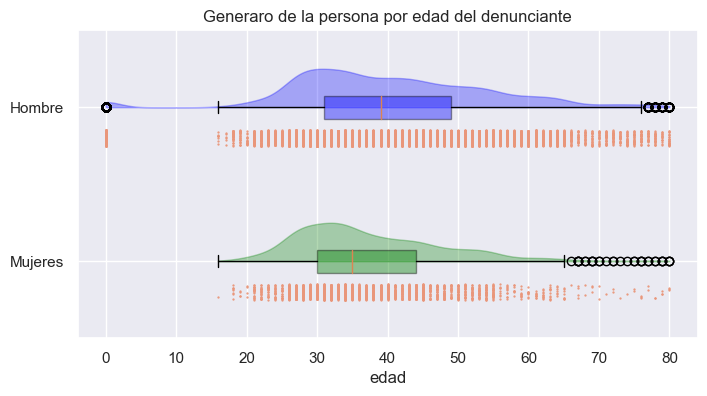

In [141]:
female_fraude = fraudes[fraudes.sex=='Female']
male_fraude = fraudes[fraudes.sex=='Male']
data_x = [female_fraude.age.to_numpy(), male_fraude.age.to_numpy()]
feats = ['Mujeres', 'Hombre']
value = 'edad'
title = 'Generaro de la persona por edad del denunciante'

raincloud_image(data_x, feats, value, title)

In [142]:
q25 = np.percentile(male_fraude.age, 25)
q75 = np.percentile(male_fraude.age, 75)
print(f'Rango de edad de hombres que hacen denuncia {q25 , q75}')

Rango de edad de hombres que hacen denuncia (31.0, 49.0)


En las anteriores imagenes, tenemos gran información, en la primera la distribucción de edades de las personas que han hecho denuncias, segmentados si la denuancia 
es un fraude o no, mientras en la segunda, vemos la distribución de edades por genero. En ambas graficas observamos que existen valores atípicos: personas que hicieron denucias 
validas y con fraude que su edad es cero, adicional, estas personas son todas hombres. Por otro lado, para nuestro interes vemos que la edad más factible (`mediana`) de las personas 
que estan haciendo fraude es 36 años, pero el rango de edad de los denunciantes hacen denuncias que son fraudes es ente los 30 y 46 años y aunque es más probable que el fraude lo realice un hombre
estre rango de edad también contiene a las mujeres.

### Rain Cloud Images para la exploración de valores atípicos (si los ubiese) en el costo del seguro.

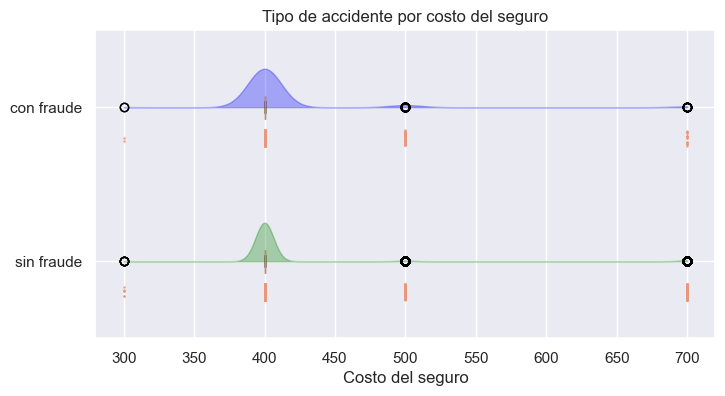

In [143]:
sin_fraude = fraudes[fraudes.fraudfound_p==0]
con_fraude = fraudes[fraudes.fraudfound_p==1]
data_x = [sin_fraude.deductible.to_numpy(), con_fraude.deductible.to_numpy()]
feats = ['sin fraude', 'con fraude']
value = 'Costo del seguro'
title = 'Tipo de accidente por costo del seguro'

raincloud_image(data_x, feats, value, title)

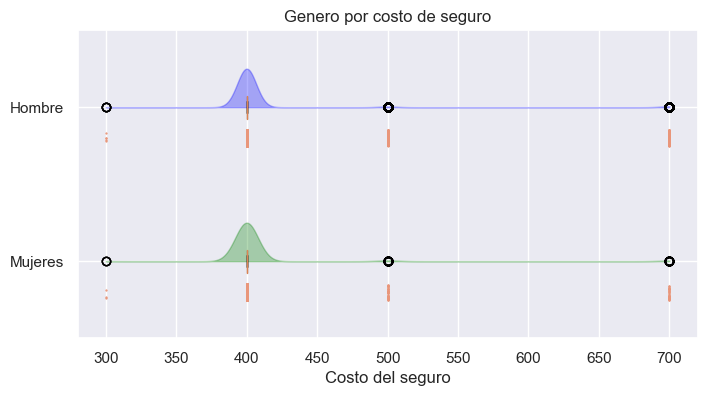

In [144]:
female_fraude = fraudes[fraudes.sex=='Female']
male_fraude = fraudes[fraudes.sex=='Male']
data_x = [female_fraude.deductible.to_numpy(), male_fraude.deductible.to_numpy()]
feats = ['Mujeres', 'Hombre']
value = 'Costo del seguro'
title = 'Genero por costo de seguro'

raincloud_image(data_x, feats, value, title)

De las anteriores imagenes podemos inferir que las denuncias realizadas que son fraudes, son a los seguros más baratos `$400` y una pequeña fracción de seguros con un valor de `$500`, 
en este caso, la variable del costo del seguro no logra hacer distinción en si el tramite es o no fraudulento. Este tipo de conclusiones las retificaremos más adelante por medio de pruebas de hipotesis.

### Desbalance en las categorias de la variable objetivo.

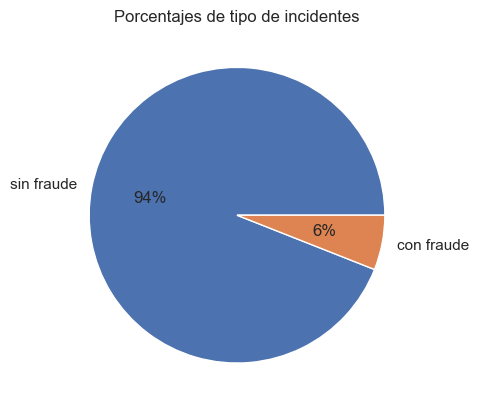

In [145]:

group_fraudes = fraudes.groupby('fraudfound_p').agg({'fraudfound_p':'count'})
group_fraudes.columns = ['cantidad']
group_fraudes.reset_index(inplace=True)
group_fraudes['fraudfound_p'] = group_fraudes['fraudfound_p'].replace(
    {0: 'sin fraude', 1:'con fraude'})

explode = [0, 0.1, 0, 0, 0]
plt.title('Porcentajes de tipo de incidentes')
plt.pie(group_fraudes.cantidad.tolist(), labels=group_fraudes.fraudfound_p.tolist(), autopct='%.0f%%')
  
# displaying chart
plt.show()

De los datos otorgados, solo el 6% hace referencia a trámites (entiendace trámite como denuncia de un incidente que puede o no ser un fraude). Esta conclusión sera un problema para nuestros futuros modelos, ya que no tenemos un equilibrio entre las categorias de nuestra variable a predeccir. Sin un tratamiento adecuado de la información, el no equilibrio entre las categorias de la variable objetivo
puede crear modelos sesgados.

### Cantidad de incidentes por unidad de tiempo

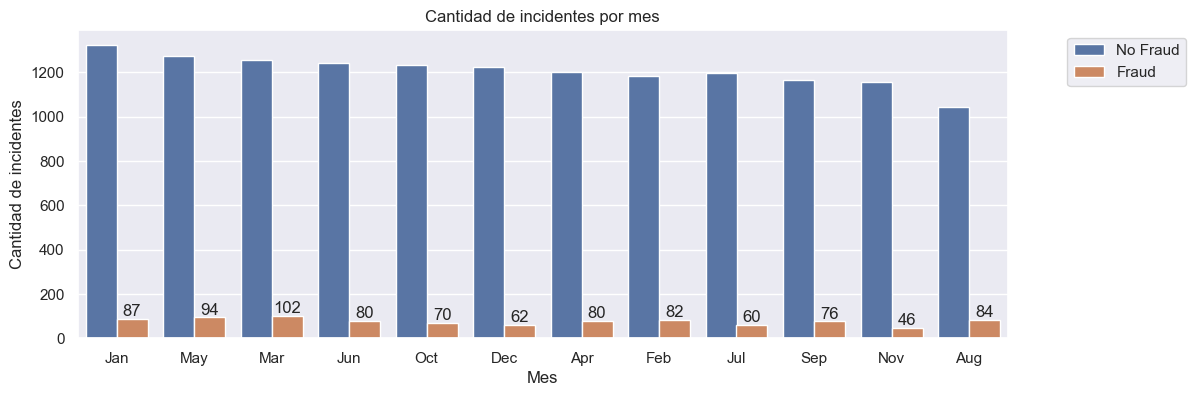

In [146]:
plt.figure(figsize=(12, 4))
sns.set(style='darkgrid')
labels = ['No Fraud', 'Fraud']
fig = sns.countplot(x="monthh", hue ='fraudfound_p', data=fraudes, order = fraudes['monthh'].value_counts().index)
fig.bar_label(fig.containers[1], label_type='edge');

plt.legend(labels,  bbox_to_anchor=(1.2, 1))
plt.title('Cantidad de incidentes por mes')
plt.ylabel('Cantidad de incidentes')
plt.xlabel('Mes')
plt.show()

In [147]:
cols = ['monthh', 'yearr', 'fraudfound_p']
agg = {'fraudfound_p': 'count'}
year_month = fraudes.groupby(cols).agg(agg)
year_month.columns = ['cantidad']
year_month.reset_index(inplace=True)
year_month_fraude = year_month[year_month.fraudfound_p==1]
year_month_fraude.sort_values('cantidad', ascending=False)

,monthh,yearr,fraudfound_p,cantidad
7,Aug,1994,1,56
41,Mar,1994,1,56
47,May,1994,1,52
61,Oct,1995,1,50
25,Jan,1994,1,48
1,Apr,1994,1,47
35,Jun,1994,1,47
43,Mar,1995,1,45
21,Feb,1995,1,45
15,Dec,1995,1,44


Observamos que en general el mes que se encontraron mayor cantidad de trámites o incidentes en enero, pero de estos incidentes, que fueron fraudes, se encuentran en el mes de Agosto y Marzo de 1994

#### Fraudes por marca de vehículo

In [148]:
cols = ['make', 'fraudfound_p']
agg = {'fraudfound_p': 'count'}
make_group = fraudes.groupby(cols).agg(agg)
make_group.columns = ['cantidad']
make_group.reset_index(inplace=True)
make_group.sort_values(['fraudfound_p','cantidad'], ascending=False)[:10]

,make,fraudfound_p,cantidad
24,Pontiac,1,213
31,Toyota,1,186
12,Honda,1,179
16,Mazda,1,123
5,Chevrolet,1,94
1,Accura,1,59
10,Ford,1,33
27,Saab,1,11
33,VW,1,8
20,Mercury,1,6


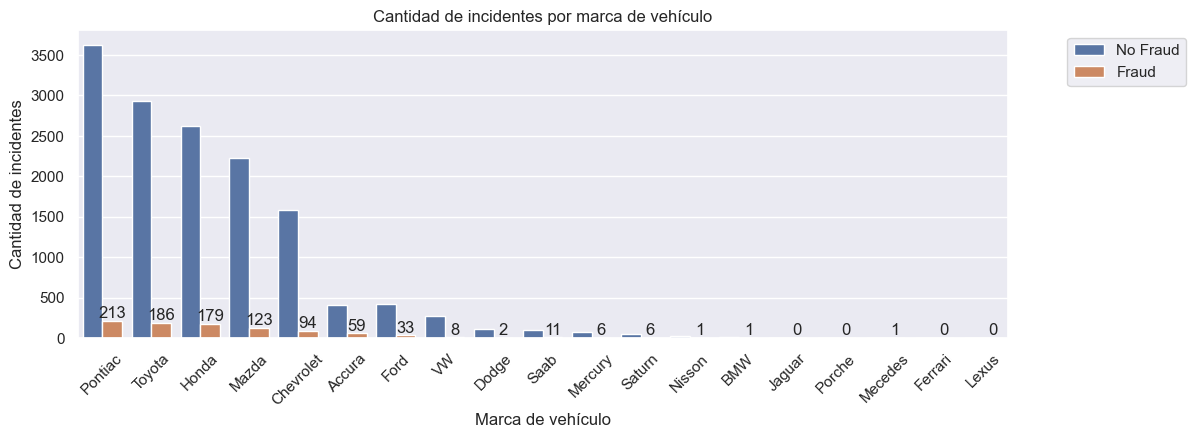

In [149]:
plt.figure(figsize=(12, 4))
sns.set(style='darkgrid')
labels = ['No Fraud', 'Fraud']
fig = sns.countplot(x="make", hue ='fraudfound_p', data=fraudes, order = fraudes['make'].value_counts().index)
fig.bar_label(fig.containers[1], label_type='edge');

plt.legend(labels,  bbox_to_anchor=(1.2, 1))
plt.title('Cantidad de incidentes por marca de vehículo')

plt.ylabel('Cantidad de incidentes')
plt.xlabel('Marca de vehículo')
plt.xticks(rotation=45)
plt.show()

La marca más implicadas en incidentes tanto fraudulentos como no fraudulentos son los Pontiac y Toyota, mientras marcas de un alto nivel adquisitico comp los BMW, Jaguar, Poeche, Mercedes, Ferrari, Leexus
poco o nada se ven imvolucados en este tipo de Denuncias, esto nos indica, que estas marcas para el tipo de problema a tratar, son ruido y no aportan valor relevante para futuros modelos de machine learning.

### Vehiculos implicados en incidentes que pueden ser fraudes

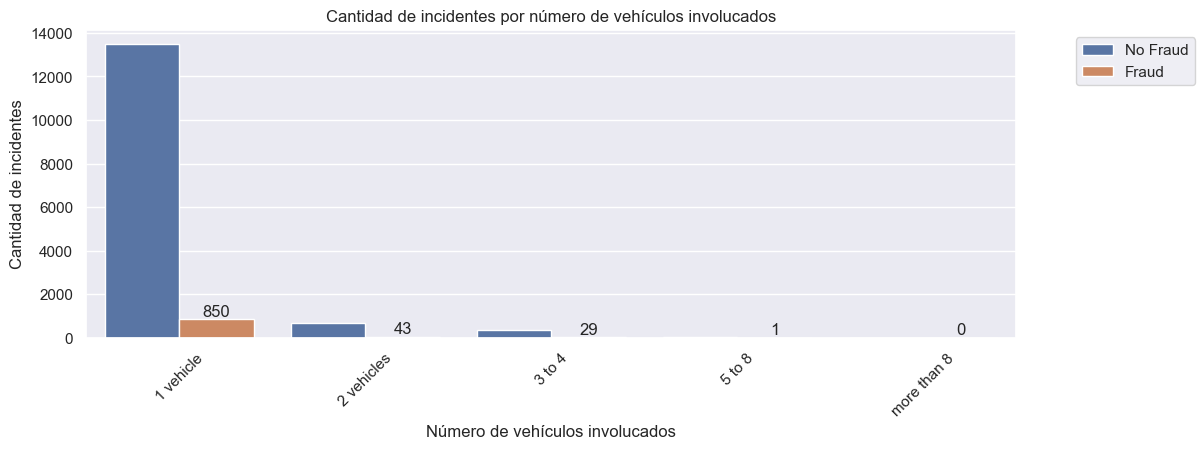

In [150]:
plt.figure(figsize=(12, 4))
sns.set(style='darkgrid')
labels = ['No Fraud', 'Fraud']
fig = sns.countplot(x="numberofcars", hue ='fraudfound_p', data=fraudes, order = fraudes['numberofcars'].value_counts().index)
fig.bar_label(fig.containers[1], label_type='edge');

plt.legend(labels,  bbox_to_anchor=(1.2, 1))
plt.title('Cantidad de incidentes por número de vehículos involucados')

plt.ylabel('Cantidad de incidentes')
plt.xlabel('Número de vehículos involucados')
plt.xticks(rotation=45)
plt.show()

La cantida de vehículos más probable de encontrar en los trámites de un incidente es de un vehíclo. 

### Cantidad de incidentes por Tipo de seguro

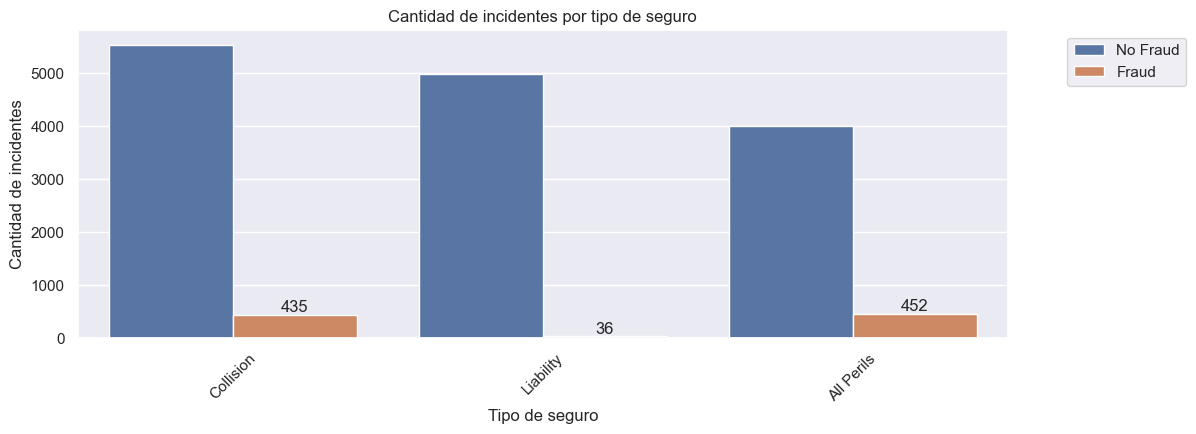

In [151]:
plt.figure(figsize=(12, 4))
sns.set(style='darkgrid')
labels = ['No Fraud', 'Fraud']
fig = sns.countplot(x="basepolicy", hue ='fraudfound_p', data=fraudes, order = fraudes['basepolicy'].value_counts().index)
fig.bar_label(fig.containers[1], label_type='edge');

plt.legend(labels,  bbox_to_anchor=(1.2, 1))
plt.title('Cantidad de incidentes por tipo de seguro')

plt.ylabel('Cantidad de incidentes')
plt.xlabel('Tipo de seguro')
plt.xticks(rotation=45)
plt.show()

Los tipos de seguros que se ven presentes en los trámites que son fraude son po Collision y All Perils, de igual manera, esta variable se vera opacada por que sus categorias no estan bien balanceadas en el caso que el incidente sea o no un fraude.

### Prueba de Hipótesis (Analísis entre variables categoricas)

Las anteriores imagenes son casos partículares de analizar la variable de interes y con las demás variables del DataFrame.Como en su mayoria poseemos variables categoricas, lo que anteriormente hicimos es gráficamente una tabla de contingencia entre dos variables, todo para ver visualmente la relación existente entre dos variables categoricas. Esto lo podemos realizar con mayor presición utilizando una prueba de hipófisis para ver que tanta correlacción existe entre nuestra variable objetivo y las demás variables del dataset. 

La prueba a usar el Chi cuadrado que comprueba si las frecuencias que se dan en la muestra difieren significativamente de las frecuencias que cabría esperar. Y su implementación o modo de uso sera el siguiente:
- Revisar el p-value para la prueba  de Chi cuadrado, si este, es menor a 0.05 tenemos evidencia significativa en los datos para decir, que la variables en cuestión tienen algun grado de correlación,
  por el contrario si el p-values es mayor a 0.05, no se tiene evidencia suficiente para indicar que las variables estan correlacionadas, por tanto la descartaremos para posteriores analísis.

In [152]:
fraudes_str = fraudes.select_dtypes(include=['object'])

In [153]:
correlaciones_chi2 = correlaciones_chi2(fraudes_str,fraudes)
   

In [154]:
correlaciones_chi2

{'monthh': 0.002,
 'make': 0.0,
 'accidentarea': 0.0,
 'monthclaimed': 0.0,
 'sex': 0.0,
 'fault': 0.0,
 'policytype': 0.0,
 'vehiclecategory': 0.0,
 'vehicleprice': 0.0,
 'days_policy_accident': 0.021,
 'pastnumberofclaims': 0.0,
 'ageofvehicle': 0.003,
 'ageofpolicyholder': 0.0,
 'agenttype': 0.007,
 'numberofsuppliments': 0.0,
 'addresschange_claim': 0.0,
 'basepolicy': 0.0}

En el caso de las variables numericas y partíclarmente la edad, la filtraremos exceptuado para futuros analísis los valores atípicos. Asumimos que lo normal es que la edad minima para realizar denducias es de 17 años. Por tanto solo tomaremos en edad, valores superiores a 17 años.

### Filtrado de datos

In [155]:
cols_str = list(correlaciones_chi2.keys())
cols_num = ['age', 'fraudfound_p', 'deductible', 'driverrating', 'yearr']
sel_cols =  cols_str + cols_num
fraudes_model = fraudes.loc[:, sel_cols]
cond_edad = fraudes_model['age'] >= 17
fraudes_model = fraudes_model[cond_edad]

## Conclusiones por agrupación que luego serán analizadas en tableros

In [188]:
fraudes_dinero = fraudes[fraudes.fraudfound_p == 1]
fraudes_dinero['yearr'] = fraudes_dinero['yearr'].astype(str)

agg = {'deductible': 'sum', 'fraudfound_p': 'count'}
cols = ['yearr', 'accidentarea']
fraudes_dinero_year_acc = fraudes_dinero.groupby(cols, as_index=False).agg(agg)
fraudes_dinero_year_acc.sort_values('deductible', ascending=False)

C:\Users\Asus\AppData\Local\Temp\ipykernel_23184\4080075740.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fraudes_dinero['yearr'] = fraudes_dinero['yearr'].astype(str)


,yearr,accidentarea,deductible,fraudfound_p
1,1994,Urban,139000,336
3,1995,Urban,106200,259
5,1996,Urban,79800,195
0,1994,Rural,29400,73
2,1995,Rural,17200,42
4,1996,Rural,7500,18


Vemos que en 1994 y en la zona Urbana fue cuando el más fraudes se cometieron y a su vez más dinero las aseguradoras perdieron, este resultado se puede contrar en el tablero generado 

In [191]:
fraudes_dinero = fraudes[fraudes.fraudfound_p == 1]
fraudes_dinero['yearr'] = fraudes_dinero['yearr'].astype(str)

agg = {'deductible': 'sum', 'fraudfound_p': 'count'}
cols = ['yearr', 'make']
fraudes_dinero_year_acc = fraudes_dinero.groupby(cols, as_index=False).agg(agg)
fraudes_dinero_year_acc.sort_values('deductible', ascending=False)[:10]

C:\Users\Asus\AppData\Local\Temp\ipykernel_23184\1485619953.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fraudes_dinero['yearr'] = fraudes_dinero['yearr'].astype(str)


,yearr,make,deductible,fraudfound_p
8,1994,Pontiac,37200,90
11,1994,Toyota,35200,84
4,1994,Honda,31700,79
20,1995,Pontiac,30500,74
23,1995,Toyota,22800,56
16,1995,Honda,22300,55
5,1994,Mazda,20300,50
33,1996,Pontiac,19800,49
36,1996,Toyota,19200,46
17,1995,Mazda,18800,46


vemos que año tras año las Pontiac son los tipos de vehículos con los que más fraudes realizan

In [194]:
fraudes_dinero = fraudes[fraudes.fraudfound_p == 1]
fraudes_dinero['yearr'] = fraudes_dinero['yearr'].astype(str)

agg = {'deductible': 'sum', 'fraudfound_p': 'count'}
cols = ['yearr', 'basepolicy']
fraudes_dinero_year_acc = fraudes_dinero.groupby(cols, as_index=False).agg(agg)
fraudes_dinero_year_acc.sort_values('deductible', ascending=False)[:10]

C:\Users\Asus\AppData\Local\Temp\ipykernel_23184\1755533752.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fraudes_dinero['yearr'] = fraudes_dinero['yearr'].astype(str)


,yearr,basepolicy,deductible,fraudfound_p
0,1994,All Perils,95700,231
1,1994,Collision,66300,163
4,1995,Collision,59800,145
3,1995,All Perils,59200,145
7,1996,Collision,52400,127
6,1996,All Perils,30900,76
2,1994,Liability,6400,15
5,1995,Liability,4400,11
8,1996,Liability,4000,10


Vemos que los seguros All Perils son los más afectados en los fraudes

In [212]:
agg = {'deductible': 'sum', 'fraudfound_p': 'count'}
cols = ['fraudfound_p']
fraudes_dinero = fraudes.groupby(cols).agg(agg)
fraudes_dinero.columns = ['dinero', 'cantida reclamaciones']
fraudes_dinero.reset_index(inplace=True)
fraudes_dinero.sort_values('dinero', ascending=False)
fraudes_dinero['porcentaje'] = fraudes_dinero['cantida reclamaciones']*100/fraudes_dinero['cantida reclamaciones'].sum()
fraudes_dinero['porcentaje'] = fraudes_dinero['porcentaje'].round(2)
fraudes_dinero

,fraudfound_p,dinero,cantida reclamaciones,porcentaje
0,0,5907700,14497,94.01
1,1,379100,923,5.99


Vemos que 923 reclamaciones fueron un fraude, es decir el 6% de los casos, lo que representa $379100 unidades de dinero

### Prepocesamiento del dataset de trabajo

Se realizara inicialmente un prepocesamiento de dataset de trabajo, transformando las variables categóricas y escalando la variables númericas, el como se hace se puede leer directamente
de la documentación de la función `prepocesar_data` creada e importada en este repositorio.

In [156]:
X = prepocesar_data(fraudes_model) #conjunto para entrenar procesados
X.drop('fraudfound_p', axis=1, inplace=True)
y = fraudes_model.fraudfound_p

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2023)

C:\Users\Asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## Entrenamiento del modelo de clasificación

### Encontrar el punto de balance o profundidad para de un arbol de desición

In [157]:
from sklearn.tree import DecisionTreeClassifier


#Números enteros de 1 a 50
max_depth_values = np.arange(1, 51, 1)

#Arreglos vacíos para almacenar el error de entrenamiento y el de generalización.
train_error = np.empty(len(max_depth_values))
generalization_error = np.empty(len(max_depth_values))


for depth in max_depth_values:
    #Entrenamos
    decision_tree = DecisionTreeClassifier(max_depth = depth)
    decision_tree.fit(X_train, y_train)
    train_error[depth - 1] = (1 - decision_tree.score(X_train, y_train))
    generalization_error[depth - 1] = (1 - decision_tree.score(X_test, y_test))

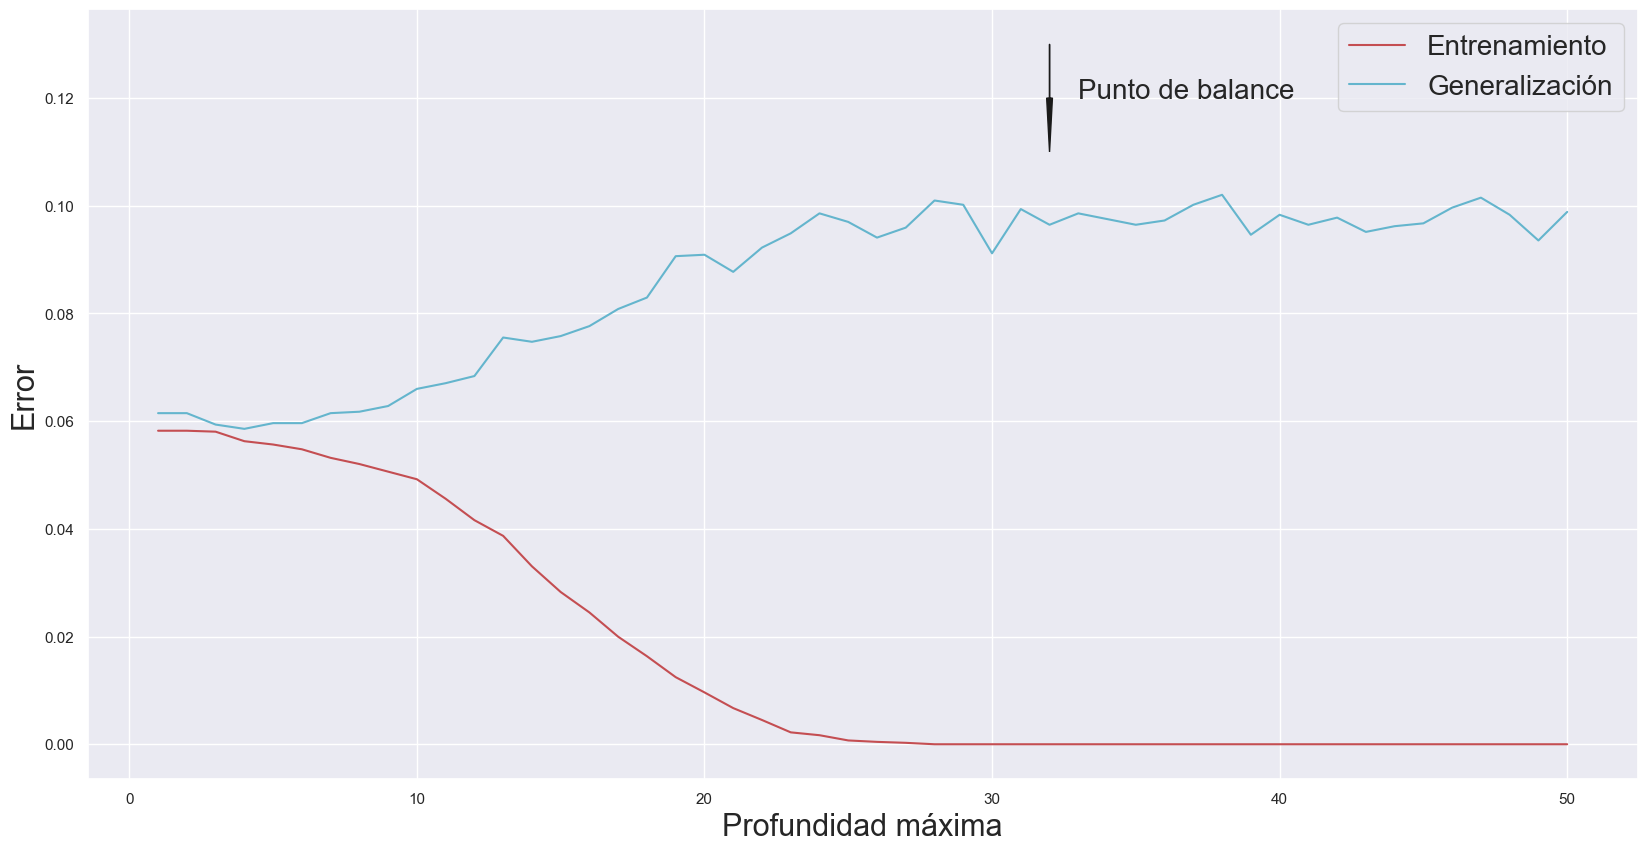

In [158]:
plt.figure(figsize=(20,10))
plt.plot(max_depth_values, train_error, label="Entrenamiento", c='r')
plt.plot(max_depth_values, generalization_error, label="Generalización",c='c')
#plt.xticks(max_depth_values)
plt.xlabel("Profundidad máxima",fontsize=22); 
plt.ylabel("Error",fontsize=22);
plt.arrow(32, 0.13, 0, -0.01, head_width=0.2, head_length=0.01, fc='k', ec='k')
plt.text(33, 0.12, 'Punto de balance',fontsize=20)

plt.legend(fontsize=20);

In [159]:
# Creación del modelo
# ------------------------------------------------------------------------------
modelo = DecisionTreeClassifier(
    max_depth=32,
    criterion='gini',
    random_state=2023)

# Entrenamiento del modelo
# ------------------------------------------------------------------------------
modelo.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=32, random_state=2023)

In [160]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
# Error de test del modelo
#-------------------------------------------------------------------------------
predicciones = modelo.predict(X = X_test)

print("Matriz de confusión")
print("-------------------")
confusion_matrix(y_true=y_test, y_pred=predicciones)

Matriz de confusión
-------------------


array([[3348,  193],
       [ 172,   60]], dtype=int64)

In [161]:
accuracy = accuracy_score(
            y_true=y_test,
            y_pred=predicciones,
            normalize=True)
print(f"El accuracy de test es: {np.round(100 * accuracy,1)} %")

El accuracy de test es: 90.3 %


In [162]:
# Predicción de probabilidades
#-------------------------------------------------------------------------------
predicciones = modelo.predict(X=X_test)
predicciones

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [163]:
from joblib import dump
from joblib import load

In [164]:
#dump(modelo, '\fraudes\model\model.pkl')
#modelo_load = load('model.pkl')

# Concluciones y posibles acciones a tomar para reducir los fraudes

De 508.860 reclamaciones que se tuvieron en cuenta, el 6 % fueron un fraude. Suena poco, pero en terminos de dinero representa $379.100 unidades de dinero que perdieron las aseguradoras.

En gran medida esto ocurrio en 1994, donde en los "accidentes" solo hubo un vehículo y estos en su mayoria eran de las marcas Pontiac y Toyota que transitaban en zona urbana. Las personas involucradas en este tipo de denuncias y por lo cual posibles estafadores, eran hombres con un rango de edad entre los 30 y 46 años que cobraban un seguro de un costo de $400 unidades de dinero. Estos factores o variables, son la posibles a tener encuentra cuando ingrese un nuevo trámite o reclamación al seguro, pues estas seran generaran alertas si el caso en cuestión es un fraude o si realmente ha sido un accidente. 

El modelo probabilistico o clasificador que dado un conjunto de variables de entrada, propias de un caso de raclamación de un seguro, permite dar una alerta si el caso a tratar es un posible fraude, sin embargo, nuestro modelo para realizar prediciones más confiables debe ser entrenado con data que este bien balanceda, ya que como esta, muy posiblemente se encuentre sobre ajustado, es decir, este aprendiendo de memoria. Por el momento, en una primera versión, el modelo es util y generalizable.

### Algunos modelos de clasificación entrenados 'de afán'.... 

In [203]:
# Importing the libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [204]:
# Creating a list of classifiers
classifiers = [
    LogisticRegression(max_iter=1000),
    SVC(max_iter=1000),
    DecisionTreeClassifier(), 
    RandomForestClassifier(), 
    KNeighborsClassifier(),
    GaussianNB(),
    GradientBoostingClassifier()]

# Creating a stratified k-fold object with 5 splits
skf = StratifiedKFold(n_splits=5)

# Looping over the classifiers
for clf in classifiers:
    # Initializing empty lists to store the evaluation metrics for each fold
    accuracies = []
    precisions = []
    recalls = []

    # Fitting the classifier on the train set
    clf.fit(X_train, y_train)
    # Predicting on the test set
    y_pred = clf.predict(X_test)
    # Calculating the evaluation metrics and appending them to the respective lists
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)

    # Printing the mean and standard deviation of the evaluation metrics for each classifier
    print(f"{clf.__class__.__name__}")
    print(f"El accuracy de test es: {np.round(100 * accuracy,1)} %")
    print(f"El precision de test es: {np.round(100 * precision,1)} %")
    print(f"El recall de test es: {np.round(100 * recall,1)} %")
    print("Matriz de confusión")
    print("-------------------")
    conf = confusion_matrix(
        y_true=y_test,
        y_pred=y_pred)
    print(conf)
    predicciones_prob = modelo.predict_proba(X=X_test)
    print('prob', predicciones_prob)
    print(pd.DataFrame(predicciones_prob)[0].unique())


LogisticRegression
El accuracy de test es: 93.7 %
El precision de test es: 0.0 %
El recall de test es: 0.0 %
Matriz de confusión
-------------------
[[3536    5]
 [ 232    0]]
prob [[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
[1. 0.]


C:\Users\Asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVC
El accuracy de test es: 93.9 %
El precision de test es: 0.0 %
El recall de test es: 0.0 %
Matriz de confusión
-------------------
[[3541    0]
 [ 232    0]]
prob [[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
[1. 0.]
DecisionTreeClassifier
El accuracy de test es: 90.5 %
El precision de test es: 24.8 %
El recall de test es: 26.7 %
Matriz de confusión
-------------------
[[3353  188]
 [ 170   62]]
prob [[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
[1. 0.]
RandomForestClassifier
El accuracy de test es: 93.9 %
El precision de test es: 50.0 %
El recall de test es: 1.3 %
Matriz de confusión
-------------------
[[3538    3]
 [ 229    3]]
prob [[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
[1. 0.]
KNeighborsClassifier
El accuracy de test es: 93.5 %
El precision de test es: 29.4 %
El recall de test es: 4.3 %
Matriz de confusión
-------------------
[[3517   24]
 [ 222   10]]
prob [[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
[1. 0.]
Gauss